# Assignment 3
## Question 1: Investigating splitting schemes

**We consider the Laplace problem −∆u(x, y) = 0 for x, y ∈ [0, 1]^2 and boundary conditions u(x, 0) = 1, u(0, y) = u(1, y) = u(x, 1) = 0. We consider a usual discretistaion of this prob- lem in terms of a 5 point finite difference stencil, leading to the linear system of equations Ax = b, where b encodes the boundary data and A represents the discrete Laplacian operator. We want to investigate solving this problem in different ways.**

In [24]:
import numpy
import numba
import pyopencl as cl
import logging

%matplotlib inline

### For Jacobi Iteration: We note that a single step of Jacobi iteration for this example at an interior point uij consists of taking the average of taking the values at all the neighboring nodes.
* First, we consider the Jacobi Iteration. Clearly, whatever if there is bound point in the five-module of every point, the formula is the same. 
* Then we use a “kernel” function to renew all variables in one step. But there is a problem that is we will also update the bound points’ variables. So after one step of Jacobi Iteration, we will initialize the bound points’ value again. 
* Moreover, we will store the relative residual in each step for drawing a convergence figure.

**The OpenCL Kernel have some parameters: __global float *u, __global float *c, __global float *r, __global const int *num_x, __global const int *num_y, which are all stored in global memory.**

In [25]:
# 1.1  pyopencl
#Create a GPU specific context and command queue
#ctx = cl.create_some_context()
ctx = cl.Context(dev_type = cl.device_type.GPU)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
mf = cl.mem_flags

# Core functions: retrieve the row and column indexes from the global id
prg = cl.Program(ctx, """
__kernel void test(__global float *u, __global float *c, __global float *r, __global const int *num_x, \
    __global const int *num_y) 
{
    int n_x = num_x[0];int n_y = num_y[0];
    float h_x = (1.0/n_x)*(1.0/n_x);float h_y = (1.0/n_y)*(1.0/n_y);
    size_t i = get_global_id(0);
    
    c[i] = (1/h_y*u[i-1] + 1/h_x*u[i-n_y-1] + 1/h_x*u[i+n_y+1] + 1/h_y*u[i+1])/(2/h_x+2/h_y);
    r[i] = (1/h_y*u[i-1] + 1/h_x*u[i-n_y-1] + 1/h_x*u[i+(n_y+1)] + 1/h_y*u[i+1] - 2*u[i]/(h_x+h_y))* \
           (1/h_y*u[i-1] + 1/h_x*u[i-n_y-1] + 1/h_x*u[i+(n_y+1)] + 1/h_y*u[i+1] - 2*u[i]*(1/h_x+1/h_y));
}
""").build()

In [26]:
num_x = num_y = 50;h_x=(1/num_x)*(1/num_x);h_y=(1/num_y)*(1/num_y)
step = 100
list_c = [0]*(num_x+1)*(num_y+1)
for j in range(num_y+1):
    list_c[j] = 0
    list_c[num_x*(num_y+1)+j] = 0
for i in range(num_x+1):
    list_c[i*(num_y+1)+num_y] = 0
    list_c[i*(num_y+1)] = 1
b_2 = 0;u = list_c;n_x = num_x;n_y = num_y
for i in range(n_x-1):#i->1,n_x-1;j->1,n_y-1
    i = i+1
    for j in range(n_y-1):
        j = j + 1
        b_v = (1/h_y)*u[i*(n_y+1)+j-1] + (1/h_x)*u[(i-1)*(n_y+1)+j] + (1/h_x)*u[(i+1)*(n_y+1)+j] \
                 + (1/h_y)*u[i*(n_y+1)+j+1] - 2*u[i*(n_y+1)+j]*(1/h_x+1/h_y)
        b_2 = b_v**2 + b_2 

c = numpy.array(list_c,dtype=numpy.float32)
n_x = numpy.array([n_x],dtype=numpy.int)
n_y = numpy.array([n_y],dtype=numpy.int)
r = numpy.array(list_c,dtype=numpy.float32)
r_v = numpy.empty(len(list_c),dtype=numpy.float32)
#u = numpy.array(range(50),dtype=numpy.float32)
list_r = []

for i in range(step):
    u = c.copy()
    u_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=u)
    c_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=c)
    r_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=r)
    x_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=n_x)
    y_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=n_y)
    
    prg.test(queue, [r.size], None, u_buf, c_buf, r_buf, x_buf, y_buf)
    cl.enqueue_copy(queue, c, c_buf)
    cl.enqueue_copy(queue, r_v, r_buf)

    for j in range(num_y+1):
        r_v[j] = 0;c[j] = 0
        r_v[num_x*(num_y+1)+j] = 0;c[num_x*(num_y+1)+j] = 0
    for i in range(num_x+1):
        r_v[i*(num_y+1)+num_y] = 0;c[i*(num_y+1)+num_y] = 0
        r_v[i*(num_y+1)] = 0;c[i*(num_y+1)] = 1
    list_r.append(sum(r_v)/b_2)

### Plot the convergence curve of Jacobi

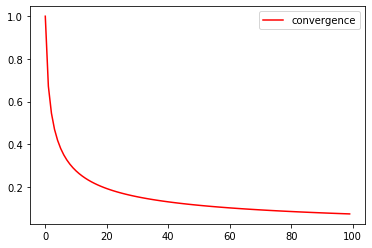

In [27]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(range(0,step,1),list_r,'r',label='convergence')
plt.legend()
plt.show()

### For Gauss-Seidel iteration: we implement three different iteration as the requirement from our assignment.
* What it is about the “parallel” one is to use previous values, equivalently, use the back-one-step value. The difference between this part and the first part is just to modify the formula in the “opencl” segment. In details, we replace back-one-step values with the values of the right and the up point. 
* For the normal iteration, the standard one is bottom-to-up method. We implement this one with the standard implementation. 
* And for the up-to-bottom one, we obtain it from the “bottom-to-up one” by changing the row index i to n - i -1.

**Noting that Gauss-Seidel works almost the same way as Jacobi. Here we implement a relaxed version of Gauss-Seidel by updating a single row in parallel and using updated values from the previous row. This allows paralellisation across a single row.**

In [28]:
# 1.2-parallel  pyopencl
num_x = num_y = 50;h_x=(1/num_x)*(1/num_x);h_y=(1/num_y)*(1/num_y)
step = 100
list_c = [0]*(num_x+1)*(num_y+1)
for j in range(num_y+1):
    list_c[j] = 0
    list_c[num_x*(num_y+1)+j] = 0
for i in range(num_x+1):
    list_c[i*(num_y+1)+num_y] = 0
    list_c[i*(num_y+1)] = 1
#||b||
b_2 = 0;u = list_c;n_x = num_x;n_y = num_y
for i in range(n_x-1):#i->1,n_x-1;j->1,n_y-1
    i = i+1
    for j in range(n_y-1):
        j = j + 1
        b_v = (1/h_y)*u[i*(n_y+1)+j-1] + (1/h_x)*u[(i-1)*(n_y+1)+j] + (1/h_x)*u[(i+1)*(n_y+1)+j] \
                 + (1/h_y)*u[i*(n_y+1)+j+1] - 2*u[i*(n_y+1)+j]*(1/h_x+1/h_y)
        b_2 = b_v**2 + b_2 
c = numpy.array(list_c,dtype=numpy.float32)
n_x = numpy.array([n_x],dtype=numpy.int)
n_y = numpy.array([n_y],dtype=numpy.int)
r = numpy.array(list_c,dtype=numpy.float32)
r_v = numpy.empty(len(list_c),dtype=numpy.float32)

# Core functions: retrieve the row and column indexes from the global id 
prg = cl.Program(ctx, """
__kernel void test(__global float *u_p, __global float *u, __global float *c, __global float *r, \
    __global const int *num_x, __global const int *num_y) 
{
    int n_x = num_x[0];int n_y = num_y[0];
    float h_x = (1.0/n_x)*(1.0/n_x);float h_y = (1.0/n_y)*(1.0/n_y);
    size_t i = get_global_id(0);
    
    c[i] = (1/h_y*u_p[i-1] + 1/h_x*u_p[i-n_y-1] + 1/h_x*u[i+n_y+1] + 1/h_y*u[i+1])/(2/h_x+2/h_y);
    r[i] = (1/h_y*u[i-1] + 1/h_x*u[i-n_y-1] + 1/h_x*u[i+(n_y+1)] + 1/h_y*u[i+1] - 2*u[i]/(h_x+h_y))* \
           (1/h_y*u[i-1] + 1/h_x*u[i-n_y-1] + 1/h_x*u[i+(n_y+1)] + 1/h_y*u[i+1] - 2*u[i]*(1/h_x+1/h_y));
}
""").build()

list_r = [];u = c.copy()
for i in range(step):
    u_p = u.copy();u = c.copy()
    u_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=u)
    c_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=c)
    u_pbuf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=u_p)
    r_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=r)
    x_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=n_x)
    y_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=n_y)
    prg.test(queue, [r.size], None, u_pbuf, u_buf, c_buf, r_buf, x_buf, y_buf)
    cl.enqueue_copy(queue, c, c_buf)
    cl.enqueue_copy(queue, r_v, r_buf)
    for j in range(num_y+1):
        r_v[j] = 0;c[j] = 0
        r_v[num_x*(num_y+1)+j] = 0;c[num_x*(num_y+1)+j] = 0;
    for i in range(num_x+1):
        r_v[i*(num_y+1)+num_y] = 0;c[i*(num_y+1)+num_y] = 0
        r_v[i*(num_y+1)] = 0;c[i*(num_y+1)] = 1
    list_r.append(sum(r_v)/b_2)

### Implement two different schemes of evaluating one step of Gauss-Seidel. 
* 1) Start with the nodes at the bottom of the square and proceed line by line to the top. 
* 2) Start at the top and proceed line by line to the bottom. Present results for both schemes.
* Implement a Numba accelerated version of Gauss-Seidel.

In [29]:
# 1.2-standard
# This function implements a bottom to top interation
def G_stepone_bottom_to_top(list_u,n_x,n_y):
    h_x = (1/n_x)**2;h_y = (1/n_y)**2;d = 0;u = list_u
    for i in range(n_x-1):
        i = i + 1
        for j in range(n_y-1):
            j = j + 1
            d = d + (1/h_y*u[i*(n_y+1)+j-1] + 1/h_x*u[i*(n_y+1)+j-n_y-1] + 1/h_x*u[i*(n_y+1)+j+(n_y+1)] \
                     + 1/h_y*u[i*(n_y+1)+j+1] - 2*u[i*(n_y+1)+j]*(1/h_x+1/h_y))**2
            u[i*(n_y+1)+j] = (1/h_y*u[i*(n_y+1)+j-1] + 1/h_x*u[(i-1)*(n_y+1)+j] + 
                              1/h_x*u[(i+1)*(n_y+1)+j] + 1/h_y*u[i*(n_y+1)+j+1])/(2/h_x+2/h_y);
    return d

# This function implements a top to bottom interation
def G_stepone_top_to_bottom(list_u,n_x,n_y):
    h_x = (1/n_x)**2;h_y = (1/n_y)**2;d = 0;u = list_u
    for i in range(n_x-1):
        i = n_x-(i + 1)
        for j in range(n_y-1):
            j = j + 1
            d = d + (1/h_y*u[i*(n_y+1)+j-1] + 1/h_x*u[i*(n_y+1)+j-n_y-1] + 1/h_x*u[i*(n_y+1)+j+(n_y+1)] \
                     + 1/h_y*u[i*(n_y+1)+j+1] - 2*u[i*(n_y+1)+j]*(1/h_x+1/h_y))**2
            u[i*(n_y+1)+j] = (1/h_y*u[i*(n_y+1)+j-1] + 1/h_x*u[(i-1)*(n_y+1)+j] + 
                              1/h_x*u[(i+1)*(n_y+1)+j] + 1/h_y*u[i*(n_y+1)+j+1])/(2/h_x+2/h_y);
    return d

list_u = [0]*(num_x+1)*(num_y+1);list_b = [];list_t = []
for j in range(num_y+1):
    list_u[j] = 0
    list_u[num_x*(num_y+1)+j] = 0
for i in range(num_x+1):
    list_u[i*(num_y+1)+num_y] = 0
    list_u[i*(num_y+1)] = 1
list_bv = list_u.copy();list_tv = list_u.copy()
for i in range(step):
    d = G_stepone_bottom_to_top(list_bv,num_x,num_y)
    list_b.append(d/b_2)
    d = G_stepone_top_to_bottom(list_tv,num_x,num_y)
    list_t.append(d/b_2)

**We implements Gauss-Seidel iterations in two ways (both bottom to top and top to bottom). And also we use the @njit decorator in Numba to improve performance (just-in-time compilation).** 

In [30]:
# 1.2-standard-using numba to accelerate
@numba.jit
# This function implements a bottom to top interation
def G_stepone_bottom_to_top(list_u,n_x,n_y):
    h_x = (1/n_x)**2;h_y = (1/n_y)**2;d = 0;u = list_u
    for i in range(n_x-1):
        i = i + 1
        for j in range(n_y-1):
            j = j + 1
            b_v = (1/h_y)*u[i*(n_y+1)+j-1] + (1/h_x)*u[(i-1)*(n_y+1)+j] + (1/h_x)*u[(i+1)*(n_y+1)+j] \
                 + (1/h_y)*u[i*(n_y+1)+j+1] - 2*u[i*(n_y+1)+j]*(1/h_x+1/h_y)
            d = b_v**2 + d
    for i in range(n_x-1):
        i = i + 1
        for j in range(n_y-1):
            j = j + 1
            u[i*(n_y+1)+j] = (1/h_y*u[i*(n_y+1)+j-1] + 1/h_x*u[(i-1)*(n_y+1)+j] + 
                              1/h_x*u[(i+1)*(n_y+1)+j] + 1/h_y*u[i*(n_y+1)+j+1])/(2/h_x+2/h_y);
    return d

@numba.jit
# This function implements a top to bottom interation
def G_stepone_top_to_bottom(list_u,n_x,n_y):
    h_x = (1/n_x)**2;h_y = (1/n_y)**2;d = 0;u = list_u
    for i in range(n_x-1):
        i = i + 1
        for j in range(n_y-1):
            j = j + 1
            b_v = (1/h_y)*u[i*(n_y+1)+j-1] + (1/h_x)*u[(i-1)*(n_y+1)+j] + (1/h_x)*u[(i+1)*(n_y+1)+j] \
                 + (1/h_y)*u[i*(n_y+1)+j+1] - 2*u[i*(n_y+1)+j]*(1/h_x+1/h_y)
            d = b_v**2 + d
    for i in range(n_x-1):
        i = n_x-(i + 1)
        for j in range(n_y-1):
            j = j + 1
            u[i*(n_y+1)+j] = (1/h_y*u[i*(n_y+1)+j-1] + 1/h_x*u[(i-1)*(n_y+1)+j] + 
                              1/h_x*u[(i+1)*(n_y+1)+j] + 1/h_y*u[i*(n_y+1)+j+1])/(2/h_x+2/h_y);
    return d

list_u = [0]*(num_x+1)*(num_y+1);list_b = [];list_t = []
for j in range(num_y+1):
    list_u[j] = 0
    list_u[num_x*(num_y+1)+j] = 0
for i in range(num_x+1):
    list_u[i*(num_y+1)+num_y] = 0
    list_u[i*(num_y+1)] = 1
list_bv = numpy.array(list_u.copy(),dtype=numpy.float32);list_tv = numpy.array(list_u.copy(),dtype=numpy.float32)
for i in range(step):
    d = G_stepone_bottom_to_top(list_bv,num_x,num_y)
    list_b.append(d/b_2)
    d = G_stepone_top_to_bottom(list_tv,num_x,num_y)
    list_t.append(d/b_2)

### Plot the convergence curve of Gauss-Seidel
* Plot both the convergence curve of this scheme with OpenCL and standard Gauss-Seidel in one picture
* We find that the standard Gauss-Seidel convergences faster than the OpenCL one
* And there is some overlap here between bottom-to-top convergence and top-to-bottom convergence, which means that the results of using these two methods are similar

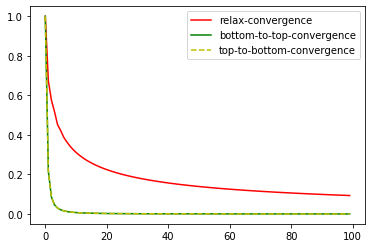

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
plt.plot(range(0,step,1),list_r,'r',label='relax-convergence')
plt.plot(range(0,step,1),list_b,'g',label='bottom-to-top-convergence')
plt.plot(range(0,step,1),list_t,'y--',label='top-to-bottom-convergence')
plt.legend()
plt.show()